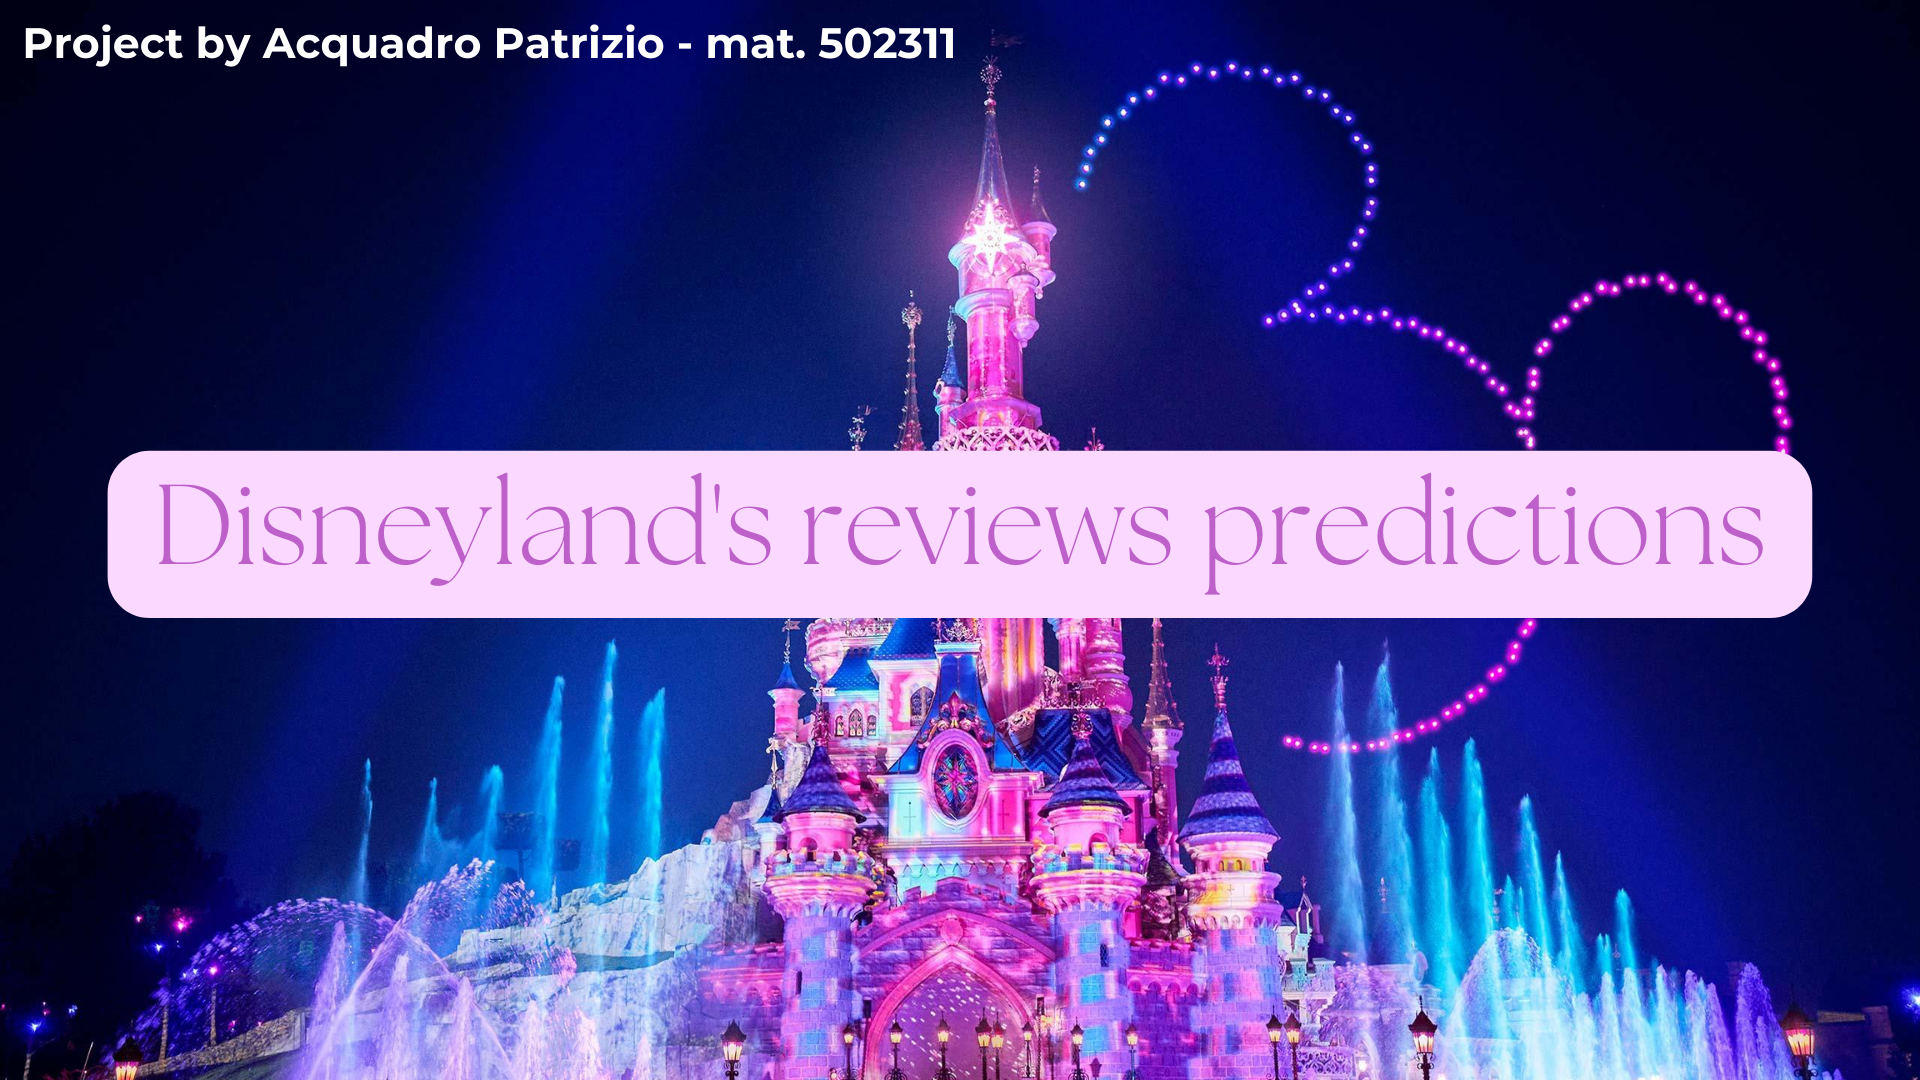

# **General Overview**
*Acquadro Patrizio - Bachelor in AI - Machine Learning, Artificial Neural Networks, Deep Learning*

In this Colab noteblock is discussed the implementation of a DNN model which analyze a dataset containing the reviews of 42656 people, about the Disneyland's parks around the world(California, Paris, Hong Kong), and which predicts if these reviews are positive or negative(with different degree between).

***The dataset:***

* is composed of 6 features(columns) with 42656 instances, which is the number of the different reviews.
* we have some missing values, of different types
* we have the feature Rating which is the target column, since this is a task of supervised learning

We analyze them in the detail below.

***The DNN model:***

The DNN model, as I specified in the answer for the first question in the written exam, is composed by 2 different models:
* an MLP, to parse the features *Year_Month, Reviewer_Location, Branch*. These are 3 categorical(strings) features.
* a Bidirectional with LSTM cells, to parse the feature Review_Text, since is a column containing the text of the written review.
The output of these 2 models is then concatenated with the respective layer, in order to perform then the classification, in the last layer.

The process for doing this will be provided below.

## **INITIATION**

##**Importing**

At the beginning of the project we import all the libraries and the different related *modules, classes and functions* that we'll use in the development of the model

In [ ]:
import keras # Import the Keras deep learning framework
print(keras.backend.backend())

tensorflow


In [ ]:
#IMPORTS
import numpy as np                  # Import the numpy numerical computation library and alias it as np
import pandas as pd                 # Import the pandas data manipulation library and alias it as pd
import tensorflow as tf             # Import the TensorFlow deep learning framework and alias it as tf
import string                       # Import the string module for string manipulation
import matplotlib.pyplot as plt     # Import the matplotlib.pyplot module for plotting with alias plt

#Importing the different methods to build the model
from keras.models import Model
from keras.layers import *
from keras.initializers import HeUniform, Zeros

#Importing the different methods for pre-processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#Importing the methods for the final evaluations of the model
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

In [ ]:
#To know the different versions
print(pd.__version__, np.__version__, tf.__version__, keras.__version__)

1.5.3 1.22.4 2.12.0 2.12.0


##**The dataframe**
We import the dataframe from a public repository that I've created on GitHub.

This is useful because now the Colab notebook is self contained, since the dataset is not installed locally or in a folder on the private google drive, and so we don't have to install it, but is directly accessible from the link below.

We use pandas to create the dataset, with method *read_csv*

The dataset is then assigned to a variable called *dataframe*

<u>Note:</u> since with GitHub free plan we can only upload files of a dimension up to 25MB, I've to compress the given dataset, since its dimension was greater. I've done this in another notebook, where I discarded some rows.

In [ ]:
url = 'https://github.com/Daedalus33/DL_Exam_CSV/blob/main/parkReviewsGH.csv?raw=true' #to define in a variable the url of the dataset
dataframe = pd.read_csv(url, on_bad_lines='skip', encoding='latin-1') #to create the dataset

In [ ]:
#To visualize the first 5(default value) rows of the dataframe
dataframe.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
1,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
2,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
3,670591897,3,2019-4,Singapore,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong
4,670574142,3,2019-3,Malaysia,Think of it as an intro to Disney magic for th...,Disneyland_HongKong


### ***New dataframe***

Since the dataset contains too many reviews, during the fit(the training) of the model, the machine shuts down due to exceeding the available RAM memory, caused by this excessive number of reviews.

This happens because we're representing each word in each review with a One-Hot vector, of lenght equal to the total number of unique words. But this number is very high. Also because we have too many misspelled words, that are seen as unique.

So then, since a review has a number of vectors equals to the number of words in the review with the maximum number of words(3963) the dimension explodes and the machine shuts down.

In [ ]:
import nltk

# Download the English language resources from NLTK
nltk.download('words')

# Create a function to count unique misspelled words in a given text
def count_misspelled_words(text):
    words = text.split()
    english_words = set(nltk.corpus.words.words())
    misspelled_words = set(word.lower() for word in words if word.lower() not in english_words and word.lower().isalpha() and word not in string.punctuation)
    return len(misspelled_words)

text_err = dataframe['Review_Text'].str.cat(sep=' ')
total_misspelled_words = count_misspelled_words(text_err)

# Print the total number of unique misspelled words
print("Total Unique Misspelled Words:", total_misspelled_words)

#As we can see, the number of misspelled words is too high(11486)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Total Unique Misspelled Words: 11486


So I've to select only a portion of the dataset I have.

I select randomly around 800 samples(I've tested this number along with my model's parameters to avoid the RAM issue) that have a number of words in the Review_Text column, between 120 and 140.

I've choose these values because the mean is 129.7 and also because I want a range of values, like in the original dataset(from 0 to 3963).

The new dataframe is called *final_df*.

In [ ]:
filtered_dataframe = dataframe[dataframe['Review_Text'].str.split().apply(lambda x: 120 <= len(x) <= 140)]
final_df = filtered_dataframe.sample(n=800, random_state=33)
final_df.shape

(800, 6)

In [ ]:
final_df.head() #to display the first 5 samples in the dataset

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
10544,189415806,1,2014-1,United States,We have been Disney supporters for many years....,Disneyland_California
13550,595660700,4,2018-7,United Kingdom,"This was our second visit to Disney Paris, we ...",Disneyland_Paris
3522,201302542,4,2013-12,Hong Kong,"Have been there a few times and, to be honest,...",Disneyland_HongKong
14837,448767733,4,2016-12,United States,We visited (as a group of two couples and one ...,Disneyland_Paris
11975,135511510,5,2012-7,United States,We took our entire family to Disneyland in Ana...,Disneyland_California


###***y and X sets***
We now get:
* the set *y* with the target column Rating, so the labels that the model has to predict
* the set *X* with all the features that are independent random variable


In [ ]:
y = final_df["Rating"]
X = final_df.drop("Rating", axis=1)

y.value_counts()

5    372
4    230
3    111
2     51
1     36
Name: Rating, dtype: int64

To visualize the distribution of the classes, I create a *bar chart* using matplotlib.

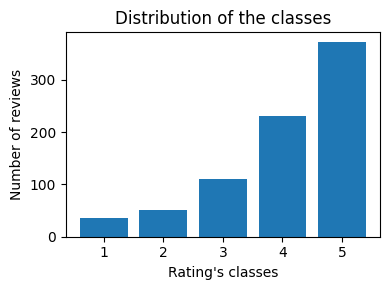

In [ ]:
class_counts = y.value_counts()

plt.figure(figsize=(4, 3))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Rating's classes")
plt.ylabel("Number of reviews")
plt.title("Distribution of the classes")
plt.tight_layout()

plt.show()

##**ANALYZE THE DATASET**
We analyze the dataset we have, to know if there are any missing value of any kind.

The info() method is used to print a concise summary of a pandas DataFrame.
It provides information about the column data types, the columns name and index, the memory usage and the number of non-null values.
So the info() method is useful to check if there are any missing values of type NaN in the dataset.

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 10544 to 2806
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          800 non-null    int64 
 1   Year_Month         800 non-null    object
 2   Reviewer_Location  800 non-null    object
 3   Review_Text        800 non-null    object
 4   Branch             800 non-null    object
dtypes: int64(1), object(4)
memory usage: 37.5+ KB


But info() detects, as I said, only missing values of type NaN.
So we might have other missing values and we check this with method value_counts.

Since the columns we will use are all categorical columns this is the right method.
Value_counts displays the frequency of each category in the column

In [ ]:
X['Year_Month'].value_counts(dropna=False)
# As we can see we have some missing values in this column.
# I'll take them into account later

missing    37
2015-5     22
2014-12    19
2016-12    19
2015-8     17
           ..
2011-4      1
2011-9      1
2011-3      1
2010-6      1
2011-2      1
Name: Year_Month, Length: 101, dtype: int64

In [ ]:
X['Reviewer_Location'].value_counts(dropna=False)
#Here we don't have any missing values

United States                        240
United Kingdom                       216
Australia                             92
Canada                                44
India                                 30
Philippines                           25
Singapore                             16
Malaysia                              11
New Zealand                           11
Ireland                                9
United Arab Emirates                   7
Germany                                6
South Africa                           6
Thailand                               6
Indonesia                              6
Netherlands                            6
France                                 4
Italy                                  4
Saudi Arabia                           4
Switzerland                            4
Qatar                                  4
Belgium                                4
Hong Kong                              3
Israel                                 3
Denmark         

In [ ]:
X['Branch'].value_counts(dropna=False)
#Also here we don't have any missing values

Disneyland_California    327
Disneyland_Paris         290
Disneyland_HongKong      183
Name: Branch, dtype: int64

# **PRE-PROCESSING**

##***Text pre-processing***
As I stated in the first question of the written exam, since the column *Review_Text* contains text, we have to convert it into a numerical form.

At first we create a variable containing all the reviews in the Review_Text column.

Then:
- we remove punctuations, undesired symbols
- we tokenize the set of all the reviews, in order to get the single words
- we create a dictionary of the unique words

This dictionary will be useful for the creation of the one-hot vector representation of the words.

In [ ]:
#Extract the column Review_Text
text = X["Review_Text"]
print(text.head(5))

10544    We have been Disney supporters for many years....
13550    This was our second visit to Disney Paris, we ...
3522     Have been there a few times and, to be honest,...
14837    We visited (as a group of two couples and one ...
11975    We took our entire family to Disneyland in Ana...
Name: Review_Text, dtype: object


In [ ]:
#Create a variable with all the reviews (separated by a blank space)
text = text.str.cat(sep=' ')

In [ ]:
print(len(text))

558027


In [ ]:
def get_words(text):
  text = text.replace('--', ' ')
  # split into tokens by white space
  words = text.split()
  # remove punctuation from each token
  table = str.maketrans('', '', string.punctuation)
  words = [w.translate(table) for w in words]
  # remove remaining tokens that are not alphabetic
  words = [word for word in words if word.isalpha()]
  # make lower case
  words = [word.lower() for word in words]
  return words

words = get_words(text) #we get the list of total words
unique = np.unique(words) #we get the list of unique words
print(words[:10])
print(f"Total words: {len(words)}")
print(f"Unique words: {len(unique)}")

['we', 'have', 'been', 'disney', 'supporters', 'for', 'many', 'years', 'but', 'each']
Total words: 101811
Unique words: 6546


In [ ]:
unique_words = np.unique(words)
unique_word_index = dict((w, i) for i, w in enumerate(unique_words))
print(len(unique_words))
print(f"Unique words:{unique_words[:5]}") #display the first 20 unique words
print(list(unique_word_index.items())[:5]) #display the first 20 elements in the dictionary(word-integer)

6546
Unique words:['a' 'aaa' 'ability' 'able' 'ablution']
[('a', 0), ('aaa', 1), ('ability', 2), ('able', 3), ('ablution', 4)]


# **Categocial columns pre-processing**

##***Split the column***
Since I've missing_values in the column Year_Month, I decide to split it and to deal them separately, in order to know better their missing values.


In [ ]:
X[['Year', 'Month']] = X['Year_Month'].str.split('-', expand=True)
X=X.drop(['Year_Month'], axis=1)
X.head()

,Review_ID,Reviewer_Location,Review_Text,Branch,Year,Month
10544,189415806,United States,We have been Disney supporters for many years....,Disneyland_California,2014,1
13550,595660700,United Kingdom,"This was our second visit to Disney Paris, we ...",Disneyland_Paris,2018,7
3522,201302542,Hong Kong,"Have been there a few times and, to be honest,...",Disneyland_HongKong,2013,12
14837,448767733,United States,We visited (as a group of two couples and one ...,Disneyland_Paris,2016,12
11975,135511510,United States,We took our entire family to Disneyland in Ana...,Disneyland_California,2012,7


In [ ]:
X['Year'].value_counts(dropna=False).sort_index(ascending=True)
#As we can see, we have some 'missing' values

2010         3
2011        24
2012        82
2013       101
2014       101
2015       134
2016       122
2017       107
2018        74
2019        15
missing     37
Name: Year, dtype: int64

In [ ]:
X['Month'].value_counts(dropna=False).sort_index(ascending=True)
#As we can see, we have some 'None' values (so missing values)

1       45
10      77
11      53
12      88
2       48
3       60
4       58
5       77
6       67
7       60
8       77
9       53
None    37
Name: Month, dtype: int64

Since the *SimpleImputer*, which is the function used to deal missing values, substitute only the Nan values with the most frequent one in the feature, we have to convert missing e None in this format


In [ ]:
X["Year"] = X["Year"].replace("missing", np.nan)
X["Month"] = X["Month"].fillna(value=np.nan)

In [ ]:
X.info()
#Now we see the missing values also with the method info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 10544 to 2806
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          800 non-null    int64 
 1   Reviewer_Location  800 non-null    object
 2   Review_Text        800 non-null    object
 3   Branch             800 non-null    object
 4   Year               763 non-null    object
 5   Month              763 non-null    object
dtypes: int64(1), object(5)
memory usage: 43.8+ KB


##***Pre-processing***
Now we have to pre-process this columns, and this is done in 2 steps:
- *Imputation:* to replace missing values with some other values. I use the SimpleImputer, which is a statistical method to fill the missing values with a certain value according to the strategy used. Here i use the most frequent value.
- *Data transformation:* to convert categorical values(strings) into numerical ones. As I wrote in the 1st answer of the written exam, I'll use a categorical encoder, in this case I use *OneHotEncoder* since order is not relevant.

These 2 steps have to be performed in sequence, so I use a *Pipeline* to make this.

Then I insert the pipeline in a *ColumnTransformer* object to transform the specified columns with the Pipeline.

In [ ]:
pipeline_OHE = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(handle_unknown='ignore')) #Since in the test set we may have unknown categories
])

In [ ]:
# Create a ColumnTransformer with the Pipeline
X_ct = ColumnTransformer(
    transformers=[
        ('1', pipeline_OHE, ["Year", "Month", "Branch", "Reviewer_Location"])
    ],
    remainder='passthrough', #to pass the columns not affected by the ColumnTransformer
    verbose_feature_names_out=False, #for a better visualization of the columns names
    sparse_threshold=0,
)

##***Checking***
At this point we **check if we've made all correct**, by visualizing the dataset. It should be without any missing value.

We use a **different dataframe** to store our dataframe without missing values, since *we cannot fit and transform the whole dataframe*, but only the train set.
So what we made is only to check if there are any missing value.

The **fit_transform** method is used to fit each transformer to its respective columns in the input data and to apply the transformations.

The **get_feature_names_out** instead is used to display the different names of the features.


In [ ]:
#To visualize the effects of the column transformer
X_transformed = pd.DataFrame(X_ct.fit_transform(X), columns=X_ct.get_feature_names_out())
X_transformed.info() #to visualize the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 80 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Year_2010                                            800 non-null    object
 1   Year_2011                                            800 non-null    object
 2   Year_2012                                            800 non-null    object
 3   Year_2013                                            800 non-null    object
 4   Year_2014                                            800 non-null    object
 5   Year_2015                                            800 non-null    object
 6   Year_2016                                            800 non-null    object
 7   Year_2017                                            800 non-null    object
 8   Year_2018                                            800 non-null    object
 9  

## **TRAINING AND TEST SETS**

In this section we split the entire dataset into training and test sets, putting **80%** of the instances in the train set, and the remaining **20%** in the test set.

The train set is used to fit the model, while the test set is used to evaluate the performance of the model on unseen data.

This process is made when we have a **supervised task**: the label class is given, and we have to predict the future instances

**Random state:** parameter for the *reproducibility* of the model. I can use any intrger number I want for it, I've decided to use the number 33 (my personal lucky number).

**Stratify:** parameter  to keep the *same proportion of the data* for each class of the target column y, in the train and test sets.
We use stratify because the classes in the vector y have their distribution, so we want to keep this same proportions also in the y_train and y_test sets.

**Shuffle:** parameter to shuffle the data in the train and test sets. Even if I've already taken randomly the samples from the dataset to create the dataset of 800 samples that I use, I decide to set shuffle to True, to see what I've to do with the original dataset.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=33, shuffle=True)

To visualize the effect of stratify:

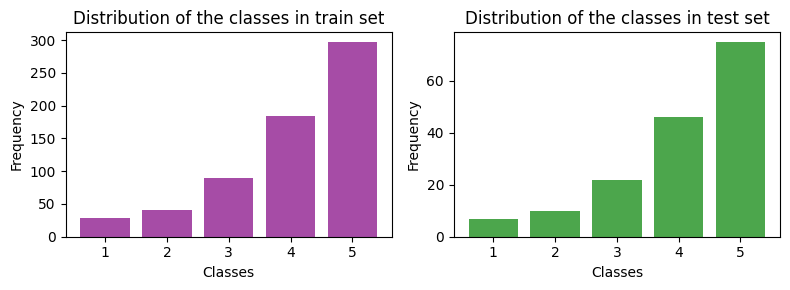

In [ ]:
# Compute the classes distributions in the train-test sets
train_class_distribution = y_train.value_counts()
test_class_distribution = y_test.value_counts()

# Plot of the distributions
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].bar(train_class_distribution.index, train_class_distribution.values, color='purple', alpha=0.7)
axes[0].set_title('Distribution of the classes in train set')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Frequency')

axes[1].bar(test_class_distribution.index, test_class_distribution.values, color='green', alpha=0.7)
axes[1].set_title('Distribution of the classes in test set')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
print("Difference: " + str(abs((sum(y_train == 1)/len(y_train)) - (sum(y_test == 1)/len(y_test)))))
print("Difference: " + str(abs((sum(y_train == 2)/len(y_train)) - (sum(y_test == 2)/len(y_test)))))
print("Difference: " + str(abs((sum(y_train == 3)/len(y_train)) - (sum(y_test == 3)/len(y_test)))))
print("Difference: " + str(abs((sum(y_train == 4)/len(y_train)) - (sum(y_test == 4)/len(y_test)))))
print("Difference: " + str(abs((sum(y_train == 5)/len(y_train)) - (sum(y_test == 5)/len(y_test)))))

#Since these numbers are very low, it means that we have the same proportions

Difference: 0.0015625000000000014
Difference: 0.0015624999999999944
Difference: 0.0015624999999999944
Difference: 0.0
Difference: 0.004687500000000011


In [ ]:
print('Shape of X_train: {}\nShape of X_test: {}'.format(X_train.shape, X_test.shape))

Shape of X_train: (640, 6)
Shape of X_test: (160, 6)


## **ONE HOT ENCODING OF THE REVIEWS**
Since we have words instead of numbers, we have to convert these strings into a numerical representation. This representation is the one hot vector.

I've tried to recreate the most similar methods seen in class for this task:
- I've set a common number of one hot vectors for each review(the max number of words that I can have in a review)
- I create arrays with integers values(all 0) of 3 dimensions:
  * the number of samples in the train set, so the number of reviews I've
  * the number of one-hot vectors I've for each review(140)
  * the lenght of each one-hot vector, which is equal to the number of unique words I've
- Then I create the one-hot vectors for the unique words in the dictionary. I set 1 as the j-th component, where j is the integer number associated to the word in the dictionary

I repeat this also for the test sets

For the words not in the dictionary we get a vector of all 0s

In [ ]:
# Max lenght of the reviews
max_words = 140

# We create an empty array to store the encoded reviews for train and test sets
encoded_train_reviews = np.zeros((len(X_train), max_words, len(unique_words)), dtype=int)
encoded_test_reviews = np.zeros((len(X_test), max_words, len(unique_words)), dtype=int)

# Perform the one-hot encoding for train set
for i, review_text in enumerate(X_train['Review_Text']):
    words = get_words(review_text)
    for j, word in enumerate(words):
        if word in unique_word_index:
            word_index = unique_word_index[word]
            encoded_train_reviews[i, j, word_index] = 1

# Perform the one-hot encoding for test set
for i, review_text in enumerate(X_test['Review_Text']):
    words = get_words(review_text)
    for j, word in enumerate(words):
        if word in unique_word_index:
            word_index = unique_word_index[word]
            encoded_test_reviews[i, j, word_index] = 1

In [ ]:
encoded_train_reviews.shape

(640, 140, 6546)

In [ ]:
encoded_test_reviews.shape

(160, 140, 6546)

In [ ]:
# Visualize one hot vectors of the first 3 words for the first 3 reviews in train and test sets
for i in range(3):
    print("Train Review Text:", X_train['Review_Text'].iloc[i])
    print("One-Hot Vector:", encoded_train_reviews[i][:2])
    print()
for i in range(3):
    print("Test Review Text:", X_test['Review_Text'].iloc[i])
    print("One-Hot Vector:", encoded_test_reviews[i][:2])
    print()

Train Review Text: We had a fun day at this Disney park, but as the park is small and the rides are geared mainly to kids under 8, the fun factor was limited for our  wild  kid. We went mid week and the lines weren't bad. Much of the food is geared to the Asian crowd and won't necessarily appeal to Westerners (the fried squid was rather nauseating!). This park is smaller than Disney Paris and MUCH smaller than Disney Anaheim or Orlando. Our daughter was in a wheelchair (with a broken foot) and could go on all but one ride (Tarzan's Treehouse). For a family of 3, it's about a $300 day (including lunch, dinner and raincoats!) Overall, I'd say it's a fun Disney experience, but not many thrill seeking rides for older kids.
One-Hot Vector: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Train Review Text: Yes it's true that queue's aren't the best way to spend your time, neither is walking forever to get nowhere but after all is said and done, Disneyland is what you make it.As long as you plan your

## **2 TRAIN SETS FOR 2 MODELS**
I've to create 2 different training sets with respect to the features I've and the model to parse them.

So, as I said at the beginning of the notebook and also in the 1st question of the written exam:
- I've a train set containg the *Review_Text* feature, where each review is encoded in a matrix of OHE vectors, to parse it with a **Bidirectional/LSTM/GRU**.
- I've another train set containing the other features *Year, Month, Reviewer_Location and Branch*, to parse them with an **MLP**.

In [ ]:
#Train set for MLP
X_train_mlp = X_train.drop(['Review_Text', 'Review_ID'], axis=1)  #Remove the column ReviewText and ReviewID
X_train_mlp = X_ct.fit_transform(X_train_mlp)  #Apply the column transform to fit and at the same time transform the train set
#Now X_train_mlp contains the transformed features Year, Month, Reviewer_Location and Branch

#Train set for the Bidirectional LSTM
X_train_bid = encoded_train_reviews  #I use the array with the one-hot vectors, that I previously created

#Verify dimensions
print("Dimensions of X_train_mlp:", X_train_mlp.shape)
print("Dimensions of X_train_bid:", X_train_bid.shape)
print("Type of X_train_mlp:", type(X_train_mlp))
print("Type of X_train_bid:", type(X_train_bid))

#As we can see we have 2 numpy arrays that can be used as inputs for our models

Dimensions of X_train_mlp: (640, 72)
Dimensions of X_train_bid: (640, 140, 6546)
Type of X_train_mlp: <class 'numpy.ndarray'>
Type of X_train_bid: <class 'numpy.ndarray'>


In [ ]:
#Let's check that no NaN elements(missing values) are present anymore
nan_count = tf.reduce_sum(tf.cast(tf.math.is_nan(X_train_mlp), tf.int32))
print("Number of NaN elements:", nan_count)

#As we can see no Nan values are present in X_train_mlp

Number of NaN elements: tf.Tensor(0, shape=(), dtype=int32)


For convention, I decide to start the classes not from 1 but from 0, since some algorithms may require this.

In [ ]:
y_train_f=y_train.apply(lambda x: x-1) #To start the classes from 0
num_classes=len(y_train_f.unique())
print(num_classes) #As we see, we have still 5 classes

5


## **THE MODEL**

The model, as I said, is formed by 2 models:
- Bidirectional with LSTM cells, to parse the reviews as matrices of OH vectors (X_train_bid). I decide to use a Bidirectional with LSTM cells, since I've the entire review available, so is better to use both the forward and backward passes.
- MLP with several layers and units, to parse the features in the X_train_mlp, that we've created before.

Then a concatenate layer is used to collect the outputs from the 2 models.
Its output will be the input of some finals Dense layers, used just before the classification layer, with the softmax function.

###***Bidirectional***
We start by creating the Bidirectional with LSTM cells.

At first I create the Input layer, which receive the input.

Then we have the different bidirectional layers with LSTM cells.
I didn't mentioned in the question 3 the activation function for it, but this was not necessary since I use the default values(which are the tanh and the sigmoid). And I didn't mentioned also in question 4 the initializer, but because also there I use the default values(Glorot and Orthogonal).

In short:
- Sigmoid: non-linear function, which squashes the values into [0, 1].
Defines, with respect to the combined input (x + h(t-1)), the percentage of information to retain or to forget from:
  - previous memory state C(t-1) (forget gate)
  - candidate values for C(t-1) (input gate) obtained from tanh(see below)
  - current C(t), parsed with tanh (output gate)
- Hyperbolic tangent(tanh): non-linear activation function, which squashes values into [-1, 1]. Creates:
  - candidate values, with respect to the combined input, to add to C(input gate)
  - potential new h state, with respect to the current memory state C(output gate)
- Glorot-Xavier: effective function with tanh or sigmoid activations, which initialize the weight’s values, taking them from a uniform distribution in [-limit, +limit].
  - limit: sqrt(2c/(fan_in + fan_out)) (where fan_in is the number of input units in the weight tensor and fan_out the number of outpu units)



In [ ]:
#Input layer
bid_input_layer = Input(shape=(max_words, len(unique_words)), name='bid_input_layer')
#Definition of the Bidirectional LSTM
bidirectional_layer = Bidirectional(LSTM(units=100, return_sequences=True))(bid_input_layer)
bidirectional_layer = Bidirectional(LSTM(units=60, return_sequences=True))(bidirectional_layer)
bidirectional_layer = Bidirectional(LSTM(units=30))(bidirectional_layer)

bidirectional_layer

<KerasTensor: shape=(None, 60) dtype=float32 (created by layer 'bidirectional_2')>

###***MLP***
At first I create the Input layer, which receive the input.

Then we have the MLP with its different Dense layers, with different number of units. Dense means that each unit of the layer is connected to all the units in the other layer.
Since I mentioned in the question 3 the activation function Leaky ReLU I will use it. And since I mentioned in question 4 the initializer He, the dropout regularizer and the batch normalization, I will use them.

This 2 latters are used in Keras as layers, That I add just after the creation of the Dense layer.

I've talked about them in detail in the written exam, since are additional aspects that I've had to mention in order to implement them in this notebook, unlike LSTM activation function and initializers.

In [ ]:
#Input layer
mlp_input_layer = Input(shape=X_train_mlp.shape[1], name='mlp_input_layer')
#Definition of the MLP
mlp_hidden = Dense(units=64, activation=LeakyReLU(), kernel_initializer=HeUniform(), bias_initializer=Zeros())(mlp_input_layer)
mlp_hidden = Dropout(0.2)(mlp_hidden)
mlp_hidden = BatchNormalization()(mlp_hidden)
mlp_hidden = Dense(units=32, activation=LeakyReLU(), kernel_initializer=HeUniform(), bias_initializer=Zeros())(mlp_hidden)
mlp_hidden = Dropout(0.2)(mlp_hidden)
mlp_hidden = BatchNormalization()(mlp_hidden)
mlp_hidden = Dense(units=16, activation=LeakyReLU(), kernel_initializer=HeUniform(), bias_initializer=Zeros())(mlp_hidden)
mlp_hidden = Dropout(0.2)(mlp_hidden)
mlp_hidden = BatchNormalization()(mlp_hidden)
mlp_hidden = Dense(units=16, activation=LeakyReLU(), kernel_initializer=HeUniform(), bias_initializer=Zeros())(mlp_hidden)
mlp_hidden = Dropout(0.2)(mlp_hidden)
mlp_hidden = BatchNormalization()(mlp_hidden)
mlp_hidden

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'batch_normalization_3')>

### ***Classification***
Now that we have parsed with an MLP and a Bidirectional the different relevant features of the dataset, I concatenate the 2 outputs from the 2 models with a concatenate layer.

Then I process this combined output with some additional Dense layers, with Dropout and BatchNormalization, for the reasons stated in the written exam, so to have in the same range the activation values and to create a more robust model, less prone to overfit.

With the last dense layer we provide the output. We have, as I stated in question 2, 5 neurons, since we have 5 different clases to predict, with softmax activation function, to provide the probability distribution as output of our classification model.

Then I create the model, giving as input the respective train for the MLP and the Bidirectional and as output the result of the last layer.

Then we compile it, so we transform it into a computational graph, to get the best execution performance. I used:
- as optimizer Adam (mentioned in question 4)
- as loss the sparse categorical cross entropy, in order to use directly the integer labels of the class, avoiding to convert them in OH vectors

And at last, we train the model. I set also as validation set the 20% of the training set, in order to evaluate the performance of the model on unseen data during its training and see if it is effectively trained.
I set 40 epochs, so the model will traverse the train set for 40 times, but at each iteration the model update its weights iteratively for a number of times equal to the number of batches we have(here 18), where each batch contains 30 samples.

In [ ]:
#Combine the outputs of the LSTM and of the MLP
combined_output = concatenate([bidirectional_layer, mlp_hidden])
#Add 1 or more layers before the classification
combined_output = Dense(units=64, activation=LeakyReLU(), kernel_initializer=HeUniform(), bias_initializer=Zeros())(combined_output)
combined_output = Dropout(0.2)(combined_output)
combined_output = BatchNormalization()(combined_output)
combined_output = Dense(units=32, activation=LeakyReLU(), kernel_initializer=HeUniform(), bias_initializer=Zeros())(combined_output)
combined_output = Dropout(0.2)(combined_output)
combined_output = BatchNormalization()(combined_output)
combined_output = Dense(units=16, activation=LeakyReLU(), kernel_initializer=HeUniform(), bias_initializer=Zeros())(combined_output)
combined_output = Dropout(0.2)(combined_output)
combined_output = BatchNormalization()(combined_output)
combined_output = Dense(units=16, activation=LeakyReLU(), kernel_initializer=HeUniform(), bias_initializer=Zeros())(combined_output)
combined_output = Dropout(0.2)(combined_output)
combined_output = BatchNormalization()(combined_output)
#Perform the classification with this last layer
combined_output = Dense(units=num_classes, activation='softmax')(combined_output)

#Create the model
model = Model(inputs=[bid_input_layer, mlp_input_layer], outputs=combined_output)

#Compile and train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit([X_train_bid, X_train_mlp], y_train_f, validation_split=0.2, epochs=40, batch_size=30, verbose=1)

Epoch 1/40
18/18 [==============================] - 32s 446ms/step - loss: 2.0854 - accuracy: 0.1992 - val_loss: 1.5979 - val_accuracy: 0.2969
Epoch 2/40
18/18 [==============================] - 5s 285ms/step - loss: 2.0421 - accuracy: 0.1973 - val_loss: 1.6028 - val_accuracy: 0.2969
Epoch 3/40
18/18 [==============================] - 4s 236ms/step - loss: 2.0068 - accuracy: 0.2031 - val_loss: 1.6118 - val_accuracy: 0.2969
Epoch 4/40
18/18 [==============================] - 4s 237ms/step - loss: 1.9672 - accuracy: 0.2227 - val_loss: 1.6252 - val_accuracy: 0.3125
Epoch 5/40
18/18 [==============================] - 5s 270ms/step - loss: 1.8765 - accuracy: 0.2285 - val_loss: 1.6807 - val_accuracy: 0.2969
Epoch 6/40
18/18 [==============================] - 4s 242ms/step - loss: 1.6923 - accuracy: 0.3105 - val_loss: 1.6550 - val_accuracy: 0.3125
Epoch 7/40
18/18 [==============================] - 4s 243ms/step - loss: 1.5516 - accuracy: 0.3477 - val_loss: 2.0019 - val_accuracy: 0.3281
Epoch

To get the total number of parameters and a compact view of the scheme of the model we use the method summary.

As we can see, the model has 5,495,589.

I've founded that this is the maximum number of parameters that I can have in my model, to avoid the problem of the RAM memory, with this number of training samples(800).

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mlp_input_layer (InputLayer)   [(None, 72)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           4672        ['mlp_input_layer[0][0]']        
                                                                                                  
 dropout (Dropout)              (None, 64)           0           ['dense[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 64)          256         ['dropout[0][0]']                
 alization)                                                                                   

# **TEST SETS**

I repeat what I've done before for the train, here for the test set.

So I create the test sets for the 2 models:
- X_test_mlp for the MLP
- X_test_bid for the Bidirectional

In [ ]:
#Test set for the MLP
X_test_mlp = X_test.drop(['Review_Text', 'Review_ID'], axis=1)
X_test_mlp = X_ct.transform(X_test_mlp)

#Train set for the Bidirectional LSTM
X_test_bid = encoded_test_reviews

#Verify the dimensions
print("Dimension of X_test_mlp: ", X_test_mlp.shape)
print("Dimension of X_test_bid: ", X_test_bid.shape)
print("Type of X_test_mlp: ", type(X_test_mlp))
print("Type of X_test_bid: ", type(X_test_bid))

Dimension of X_test_mlp:  (160, 72)
Dimension of X_test_bid:  (160, 140, 6546)
Type of X_test_mlp:  <class 'numpy.ndarray'>
Type of X_test_bid:  <class 'numpy.ndarray'>


In [ ]:
#Let's check that no NaN elements are present anymore
nan_count = tf.reduce_sum(tf.cast(tf.math.is_nan(X_test_mlp), tf.int32))
print("Number of Nan elements: ", nan_count)

#As we can see no Nan values are present in X_train_mlp

Number of Nan elements:  tf.Tensor(0, shape=(), dtype=int32)


In [ ]:
y_test_f = y_test.apply(lambda x: x - 1)
num_classes = len(y_test_f.unique())
print(num_classes)

5


We use the model to make the predictions on the unseen data(data not seen during the training).

These unseen data are the test sets for the bidirectional and the mlp.

In [ ]:
y_pred = model.predict([X_test_bid, X_test_mlp])

5/5 [==============================] - 4s 147ms/step


## **CONCLUSIONS**

###***Performance metrics***
As I've written in the question 6, I use different metrics to assess the performance of the model.

These are:
- accuracy: percentage of right predictions, over the total number of predictions by the model
- precision: percentage of right positive predictions, over the total number of positive predictions by the model
- recall: percentage of right positive predictions, over the total number of positive elements in the dataset
- f1: combines precision and recall

In [ ]:
#Compute the different metrics
accuracy = accuracy_score(y_test_f, y_pred.argmax(axis=1))
precision = precision_score(y_test_f, y_pred.argmax(axis=1), average='weighted')
recall = recall_score(y_test_f, y_pred.argmax(axis=1), average='weighted')
f1 = f1_score(y_test_f, y_pred.argmax(axis=1), average='weighted')

#Visualize the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-score: {:.2f}%".format(f1 * 100))


Accuracy: 46.88%
Precision: 21.97%
Recall: 46.88%
F1-score: 29.92%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We **plot** the *different scores* getted from the different performance metrics.

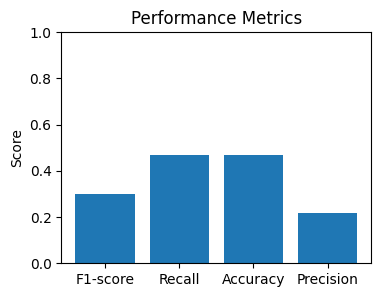

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.bar(['F1-score', 'Recall', 'Accuracy', 'Precision'], [f1, recall, accuracy, precision])
ax.set_ylim([0, 1])
ax.set_title('Performance Metrics')
ax.set_ylabel('Score')
plt.show()

As we can see, the model has no great performances because we've only few reviews(less than 1000) and we use as embedding for the words the one hot vectors. There are more efficient techniques that will guide to better performance, like Word2Vec, GloVe and others.

In addition, since we're limited memory usage, we were limited in the development of the model.
So if we add more layers and more units, we will get better performances.

But we've also be aware of the problems of exploding gradient and vanishing gradient, for which the training become not effective. We start by limiting this problem by using Leaky ReLu and the He initializer.

We conclude by visualizing some errors of the models, in order to understand more clearly the bad performances of the model.

In [ ]:
import random

#Compute the errors indeces
error_indices = []
for i in range(len(y_test)):
    if y_pred[i].argmax() != y_test_f.iloc[i]:
        error_indices.append(i)

#Number of errors examples to visualize
num_examples = 3

#Select randomly some errors
random_indices = random.sample(error_indices, num_examples)

#Visualize the errors
for idx in random_indices:
    predicted_class = y_pred[idx].argmax()
    true_class = y_test_f.iloc[idx]
    example_text = X_test.iloc[idx]['Review_Text']

    print(f"Index: {idx}")
    print(f"Wrong prediction: {predicted_class} (Probability: {y_pred[idx][predicted_class]:.4f})")
    print(f"Real clas: {true_class}")
    print(f"Text: {example_text}\n")

Index: 130
Wrong prediction: 4 (Probability: 0.4244)
Real clas: 2
Text: It's a smaller park than Florida and it's not really as Christmassy as you would think. Was really busy but died down after 4 and the wait times were only like 10 30mins instead of 60 mins. The lines a fluent . Would recommend single rider if that's possible with your group. You can fast pass but they are only available at certain times. You can get more than one at a time aswell but I think you have to wait an hour or so. The fireworks were okay but nothing compared to Florida. The light parade was amazing! A must see! Was quaint but busy park. Downtown Disney wasn't much to see, city walk was better. Has the lego shop and a big Disney store and lots of food places. If theres a choice between Florida or California,definitely Florida. 

Index: 104
Wrong prediction: 4 (Probability: 0.3902)
Real clas: 3
Text: No place in the world brings a wide grin to the faces of children or the inner child out of an adult like Dis